# Step1: 检查路径及所有的库是否齐全。

In [19]:
# Matplotlib: 设置中文字体，避免 DejaVu Sans 缺少 CJK 字形的警告（在 Windows 上优先）
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
candidates = ['Microsoft YaHei','SimHei','SimSun','Arial Unicode MS','Noto Sans CJK JP']
avail = {f.name for f in fm.fontManager.ttflist}
chosen = None
for c in candidates:
    if c in avail:
        chosen = c
        break
if chosen is not None:
    matplotlib.rcParams['font.sans-serif'] = [chosen]
    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['axes.unicode_minus'] = False  # 负号正常显示
    print('Set matplotlib font to', chosen)
else:
    # 若未找到常见中文字体，提示用户安装或自行设置 rcParams
    matplotlib.rcParams['axes.unicode_minus'] = False
    print('No common CJK font found. Chinese labels may not render correctly. Please install a CJK font or set rcParams manually.')

Set matplotlib font to Microsoft YaHei


In [1]:
# 检查文件夹路径是否正确
import os
os.chdir("D:\\Desktop\\Neural Symbolic\\Code\\GITCode\\TransNAR")
os.getcwd()

'D:\\Desktop\\Neural Symbolic\\Code\\GITCode\\TransNAR'

In [2]:
# 检查所需的基本库是否齐全
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torch_geometric
from torch_geometric.nn import GINConv

from salsaclrs import SALSACLRSDataset, SALSACLRSDataLoader

# 导入自定义模块以确保它们可用
from models.nar import NARGNN
from models.transnar import TransNARModel
from utils.tokenizer import SimpleTokenizer

print("torch version:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("pyg version:", torch_geometric.__version__)
print("salsaclrs imported OK")


torch version: 2.9.0+cu128
cuda available: True
pyg version: 2.7.0
salsaclrs imported OK


# Step2: 检查图数据是否存在并查看格式。

In [ ]:
from salsaclrs import SALSACLRSDataset, SALSACLRSDataLoader

# 创建图数据集实例
graph_ds = SALSACLRSDataset(
    root="data/raw",
    split="train", # 训练集
    algorithm="bfs", # BFS 广度优先搜索
    num_samples=10000, # 样本数量
    graph_generator="er", # ER 随机图
    graph_generator_kwargs={"n": 16, "p": 0.1}, # 图生成器参数 n 节点数, p 边概率
    hints=True, # 是否包含提示信息
)

# 输出图数据集的信息
print("num graphs:", len(graph_ds)) # should be 10000 图的数量
g0 = graph_ds[0] # 获取第一个图
print("g0:", g0) # 查看第一个图的详细信息
print("  edge_index shape:", g0.edge_index.shape) # 图结构 BFS输入
print("  pos shape:", g0.pos.shape) # 节点ID
print("  s shape:", g0.s.shape)     # BFS源点
print("  reach_h shape:", g0.reach_h.shape) # 可达高度形状

num graphs: 10000
g0: CLRSData(edge_index=[2, 48], pos=[16], length=8, s=[16], pi=[48], reach_h=[16, 8], pi_h=[48, 8], hints=[2], inputs=[2], outputs=[1])
  edge_index shape: torch.Size([2, 48])
  pos shape: torch.Size([16])
  s shape: torch.Size([16])
  reach_h shape: torch.Size([16, 8])


In [10]:
# 创建数据加载器并获取一个批次 
# 确保CLRS图数据能够正确地进行批处理 batch
graph_loader = SALSACLRSDataLoader(graph_ds,  # 刚刚创建的图数据集
                                   batch_size=32,  # 批次大小
                                   shuffle=True # 是否打乱数据
                                   ) # 创建数据加载器
batch0 = next(iter(graph_loader)) # 获取第一个批次
print("batch0:", batch0) # 查看批次的详细信息
print("  batch edge_index:", batch0.edge_index.shape)
print("  batch pos:", batch0.pos.shape)
print("  batch reach_h:", batch0.reach_h.shape)
print("  batch batch vector:", batch0.batch.shape) # 批次向量形状

batch0: CLRSDataBatch(edge_index=[2, 1680], pos=[512], length=[32], s=[512], pi=[1680], reach_h=[512, 11], pi_h=[1680, 11], hints=[2], inputs=[2], outputs=[1], batch=[512], ptr=[33])
  batch edge_index: torch.Size([2, 1680])
  batch pos: torch.Size([512])
  batch reach_h: torch.Size([512, 11])
  batch batch vector: torch.Size([512])


# Step3：图可视化

In [15]:
# 准备
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
from salsaclrs import SALSACLRSDataset

# 加载你之前的 BFS 图数据集
graph_ds = SALSACLRSDataLoader = SALSACLRSDataset(
    root="data/raw",
    split="train",
    algorithm="bfs",
    num_samples=10000,
    graph_generator="er",
    graph_generator_kwargs={"n": 16, "p": 0.1},
    hints=True,
)

g0 = graph_ds[0]     # 取第一个图
G = to_networkx(g0, to_undirected=True)

print("g0:", g0)


g0: CLRSData(edge_index=[2, 48], pos=[16], length=8, s=[16], pi=[48], reach_h=[16, 8], pi_h=[48, 8], hints=[2], inputs=[2], outputs=[1])


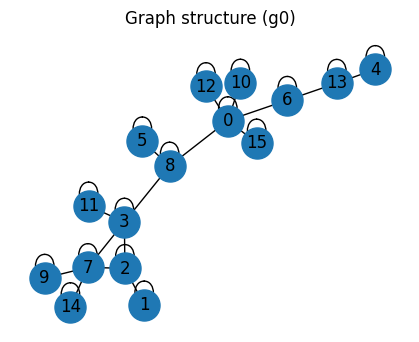

In [21]:
# 绘制第一个图
plt.figure(figsize=(4, 3))
pos = nx.spring_layout(G, seed=42)
nx.draw(G,    
        pos,  
        with_labels=True, 
        node_size=500)
plt.title("Graph structure (g0)")
plt.show()

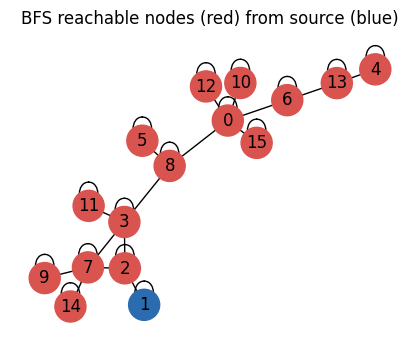

In [38]:
# 取 BFS 源点
s = g0.s
if s.ndim > 1:
    s = s[:, 0]
src = int(torch.argmax(s).item())

# 最终可达性
reach = g0.reach_h[:, -1]    # [num_nodes]
reachable_nodes = set(i for i, v in enumerate(reach.tolist()) if v > 0.5)

# 配置颜色
node_colors = []
for node in G.nodes():
    if node == src:
        node_colors.append("#2b6cb0")
    elif node in reachable_nodes:
        node_colors.append("#d9534f")
    else:
        node_colors.append("lightgray")

plt.figure(figsize=(4, 3))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=500, node_color=node_colors)
plt.title("BFS reachable nodes (red) from source (blue)")
plt.show()

BFS layers:
  Level 0: [1]
  Level 1: [2]
  Level 2: [3, 7]
  Level 3: [8, 9, 11, 14]
  Level 4: [0, 5]
  Level 5: [6, 10, 12, 15]
  Level 6: [13]
  Level 7: [4]


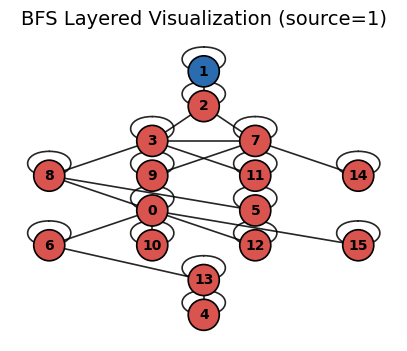

In [30]:
import matplotlib.pyplot as plt
import networkx as nx

# ---- BFS 层级计算 ----
levels = dict(nx.single_source_shortest_path_length(G, src))

# 按 level 分组节点
level_nodes = {}
for node, d in levels.items():
    level_nodes.setdefault(d, []).append(node)

print("BFS layers:")
for lvl in sorted(level_nodes.keys()):
    print(f"  Level {lvl}: {sorted(level_nodes[lvl])}")


# ---- 布局：按层排布 ----
pos = {}
x_spacing = 2.0
y_spacing = 1.6

for lvl, nodes in sorted(level_nodes.items()):
    k = len(nodes)
    x0 = -(k - 1) / 2.0 * x_spacing
    for i, node in enumerate(sorted(nodes)):
        pos[node] = (x0 + i * x_spacing, -lvl * y_spacing)


# ---- 颜色方案 ----
node_colors = []
for node in G.nodes():
    if node == src:
        node_colors.append("#2b6cb0")  # 蓝色（源点）
    elif node in reachable_nodes:
        node_colors.append("#d9534f")  # 红色（可达）
    else:
        node_colors.append("lightgray")  # 不可达


# ---- 绘制（不画 level） ----
plt.figure(figsize=(5, 4))

# 节点 + 边 + 标签
nx.draw_networkx_nodes(
    G,
    pos,
    node_color=node_colors,
    node_size=500, # 节点大小
    edgecolors="black",
    linewidths=1.2
)
nx.draw_networkx_labels(
    G,
    pos,
    font_size=10,
    font_weight="bold"
)
nx.draw_networkx_edges(
    G,
    pos,
    width=1.2,
    alpha=0.85
)

plt.title(f"BFS Layered Visualization (source={src})", fontsize=14)
plt.axis("off")
plt.show()


In [31]:
import numpy as np

# 用 spring_layout 或你之前的 BFS 分层布局都可以，这里用 spring_layout
pos = nx.spring_layout(G, seed=42)

# reach_h: [num_nodes, T]，每一列一个时间步
reach_h = g0.reach_h    # torch tensor
reach_np = reach_h.numpy()
num_nodes, T = reach_np.shape
print("reach_h shape:", reach_np.shape)  # (N, T)


reach_h shape: (16, 8)


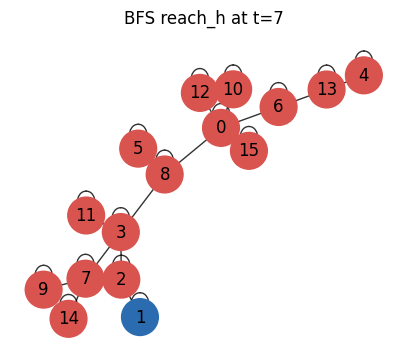

In [47]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
from IPython.display import HTML

# ----------- 动画核心部分（你已有的）----------------

def get_colors_at_t(t):
    colors = []
    for i, node in enumerate(nodes):
        if node == src:
            colors.append("#2b6cb0")  # 蓝
        else:
            v = reach_np[i, t]
            if v > 0.5:
                colors.append("#d9534f")  # 红
            else:
                colors.append("lightgray")  # 灰
    return colors

fig, ax = plt.subplots(figsize=(5,4))

edges = nx.draw_networkx_edges(G, pos, ax=ax, width=1.0, alpha=0.8)
nodes_artist = nx.draw_networkx_nodes(
    G, pos, ax=ax,
    node_color=get_colors_at_t(0),
    node_size=700,
    edgecolors="black",
    linewidths=1.0
)
nx.draw_networkx_labels(G, pos, ax=ax)

title = ax.text(0.5, 1.03, "", transform=ax.transAxes,
                ha="center", va="bottom", fontsize=12)

ax.axis("off")

def init():
    nodes_artist.set_color(get_colors_at_t(0))
    title.set_text("BFS reach_h at t=0")
    return nodes_artist, title

def update(frame):
    nodes_artist.set_color(get_colors_at_t(frame))
    title.set_text(f"BFS reach_h at t={frame}")
    return nodes_artist, title

anim = FuncAnimation(
    fig,
    update,
    frames=T,
    init_func=init,
    interval=800,
    blit=True
)

# ----------- 保存为 GIF ----------------

# 注意：writer="pillow" 可以在 Windows 无痛运行
anim.save("Figure/bfs_animation.gif", writer="pillow", fps=2)

plt.show()
plt.close(fig)



# Step4：检查文本数据

In [ ]:
# 文本文件是否存在
import os
text_path = "data/text/bfs_text_train.jsonl"
print("文件是否存在：", os.path.exists(text_path))
print("文件大小（字节）：", os.path.getsize(text_path))

文件是否存在： True
文件大小（字节）： 3002574


In [ ]:
# 检查文本文件内容 jsonl 格式是否正确
import json
with open("data/text/bfs_text_train.jsonl", "r", encoding="utf-8") as f:
    for i in range(5):   # 查看前 5 行
        line = f.readline()
        print(json.loads(line))


{'text_in': 'bfs: n=16, edges=[(0, 0), (0, 6), (0, 8), (0, 10), (0, 12), (0, 15), (1, 1), (1, 2), (2, 1), (2, 2), (2, 3), (2, 7), (3, 2), (3, 3), (3, 7), (3, 8), (3, 11), (4, 4), (4, 13), (5, 5), (5, 8), (6, 0), (6, 6), (6, 13), (7, 2), (7, 3), (7, 7), (7, 9), (7, 14), (8, 0), (8, 3), (8, 5), (8, 8), (9, 7), (9, 9), (10, 0), (10, 10), (11, 3), (11, 11), (12, 0), (12, 12), (13, 4), (13, 6), (13, 13), (14, 7), (14, 14), (15, 0), (15, 15)], start=1', 'text_out': 'reachable: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]', 'graph_idx': 0}
{'text_in': 'bfs: n=16, edges=[(0, 0), (0, 5), (0, 8), (0, 11), (1, 1), (1, 4), (1, 8), (1, 10), (2, 2), (2, 4), (2, 6), (3, 3), (3, 6), (3, 8), (3, 11), (3, 13), (4, 1), (4, 2), (4, 4), (4, 14), (5, 0), (5, 5), (6, 2), (6, 3), (6, 6), (7, 7), (7, 9), (7, 15), (8, 0), (8, 1), (8, 3), (8, 8), (8, 9), (9, 7), (9, 8), (9, 9), (10, 1), (10, 10), (10, 12), (11, 0), (11, 3), (11, 11), (12, 10), (12, 12), (13, 3), (13, 13), (13, 14), (14, 4), (14, 13), (14, 14

In [ ]:
# 读一条文本 → 对照原图结构
# 读取文本
import json
with open("data/text/bfs_text_train.jsonl", "r", encoding="utf-8") as f:
    sample = json.loads(f.readline())
sample


{'text_in': 'bfs: n=16, edges=[(0, 0), (0, 6), (0, 8), (0, 10), (0, 12), (0, 15), (1, 1), (1, 2), (2, 1), (2, 2), (2, 3), (2, 7), (3, 2), (3, 3), (3, 7), (3, 8), (3, 11), (4, 4), (4, 13), (5, 5), (5, 8), (6, 0), (6, 6), (6, 13), (7, 2), (7, 3), (7, 7), (7, 9), (7, 14), (8, 0), (8, 3), (8, 5), (8, 8), (9, 7), (9, 9), (10, 0), (10, 10), (11, 3), (11, 11), (12, 0), (12, 12), (13, 4), (13, 6), (13, 13), (14, 7), (14, 14), (15, 0), (15, 15)], start=1',
 'text_out': 'reachable: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]',
 'graph_idx': 0}

In [ ]:
# 对照图结构 保持一致
g = graph_ds[sample["graph_idx"]]
print(g.edge_index)
print(g.reach_h[:, -1])
print(sample["text_in"])
print(sample["text_out"])

tensor([[ 0,  0,  0,  0,  0,  0,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,
          4,  5,  5,  6,  6,  6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  9,  9, 10,
         10, 11, 11, 12, 12, 13, 13, 13, 14, 14, 15, 15],
        [ 0,  6,  8, 10, 12, 15,  1,  2,  1,  2,  3,  7,  2,  3,  7,  8, 11,  4,
         13,  5,  8,  0,  6, 13,  2,  3,  7,  9, 14,  0,  3,  5,  8,  7,  9,  0,
         10,  3, 11,  0, 12,  4,  6, 13,  7, 14,  0, 15]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
bfs: n=16, edges=[(0, 0), (0, 6), (0, 8), (0, 10), (0, 12), (0, 15), (1, 1), (1, 2), (2, 1), (2, 2), (2, 3), (2, 7), (3, 2), (3, 3), (3, 7), (3, 8), (3, 11), (4, 4), (4, 13), (5, 5), (5, 8), (6, 0), (6, 6), (6, 13), (7, 2), (7, 3), (7, 7), (7, 9), (7, 14), (8, 0), (8, 3), (8, 5), (8, 8), (9, 7), (9, 9), (10, 0), (10, 10), (11, 3), (11, 11), (12, 0), (12, 12), (13, 4), (13, 6), (13, 13), (14, 7), (14, 14), (15, 0), (15, 15)], start=1
reachable: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

# Step5：检查Tokenizer

In [ ]:
# build vocab 检查 tokenizer
import json
from utils.tokenizer import SimpleTokenizer

text_path = "data/text/bfs_text_train.jsonl"

# 收集所有 text_in 和 text_out
texts = []
with open(text_path, "r", encoding="utf-8") as f:
    for line in f:
        obj = json.loads(line)
        texts.append(obj["text_in"])
        texts.append(obj["text_out"])

print("样本条数（包含 in/out）：", len(texts))

# 用你的 tokenizer 建 vocab
tok = SimpleTokenizer(min_freq=1)
tok.build_vocab(texts)

print("Vocab size:", tok.vocab_size)
print("前 30 个 token:", tok.id2token[:30])
print("PAD token id:", tok.token2id[tok.pad_token])  # 填充序列
print("UNK token id:", tok.token2id[tok.unk_token])  # 未知词
print("BOS token id:", tok.token2id[tok.bos_token])  # 句子开始
print("EOS token id:", tok.token2id[tok.eos_token])  # 句子结束

样本条数（包含 in/out）： 10000
Vocab size: 33
前 30 个 token: ['<pad>', '<unk>', '<bos>', '<eos>', 'bfs', ':', 'n', '=', '16', ',', 'edges', '[', '(', '0', ')', '6', '8', '10', '12', '15', '1', '2', '3', '7', '11', '4', '13', '5', '9', '14']
PAD token id: 0
UNK token id: 1
BOS token id: 2
EOS token id: 3


In [68]:
# 检查 tokenizer 的 tokenize, encode, decode 功能
import random, json

# 随机挑一条样本
with open(text_path, "r", encoding="utf-8") as f:
    lines = f.readlines()

sample = json.loads(random.choice(lines))
print("原始 text_in :", sample["text_in"])
print("原始 text_out:", sample["text_out"])

# 看 tokenizer.tokenize 的效果
print("\n[Tokenize text_in]")
print(tok.tokenize(sample["text_in"]))

print("\n[Tokenize text_out]")
print(tok.tokenize(sample["text_out"]))

# encode + decode
ids_in = tok.encode(sample["text_in"], add_special_tokens=True, max_len=512)
ids_out = tok.encode(sample["text_out"], add_special_tokens=True, max_len=512)

print("\n[Encoded ids_in]:", ids_in)
print("[Decoded text_in ]:", tok.decode(ids_in))

print("\n[Encoded ids_out]:", ids_out)
print("[Decoded text_out ]:", tok.decode(ids_out))


原始 text_in : bfs: n=16, edges=[(0, 0), (0, 3), (0, 9), (0, 13), (1, 1), (1, 7), (1, 8), (1, 11), (2, 2), (2, 8), (2, 14), (3, 0), (3, 3), (3, 9), (4, 4), (4, 5), (4, 10), (4, 15), (5, 4), (5, 5), (5, 12), (6, 6), (6, 8), (7, 1), (7, 7), (7, 8), (8, 1), (8, 2), (8, 6), (8, 7), (8, 8), (8, 9), (9, 0), (9, 3), (9, 8), (9, 9), (10, 4), (10, 10), (10, 13), (11, 1), (11, 11), (12, 5), (12, 12), (13, 0), (13, 10), (13, 13), (14, 2), (14, 14), (15, 4), (15, 15)], start=7
原始 text_out: reachable: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

[Tokenize text_in]
['bfs', ':', 'n', '=', '16', ',', 'edges', '=', '[', '(', '0', ',', '0', ')', ',', '(', '0', ',', '3', ')', ',', '(', '0', ',', '9', ')', ',', '(', '0', ',', '13', ')', ',', '(', '1', ',', '1', ')', ',', '(', '1', ',', '7', ')', ',', '(', '1', ',', '8', ')', ',', '(', '1', ',', '11', ')', ',', '(', '2', ',', '2', ')', ',', '(', '2', ',', '8', ')', ',', '(', '2', ',', '14', ')', ',', '(', '3', ',', '0', ')', ',', '(', '3', ',', '3', ')'

In [69]:
# 检查序列长度分布
lengths = []
with open(text_path, "r", encoding="utf-8") as f:
    for line in f:
        obj = json.loads(line)
        full_text = obj["text_in"] + " " + obj["text_out"]
        ids = tok.encode(full_text, add_special_tokens=True)  # 不截断
        lengths.append(len(ids))

print("样本数:", len(lengths))
print("最长长度:", max(lengths))
print("平均长度:", sum(lengths) / len(lengths))
print("前 20 个长度:", lengths[:20])

样本数: 5000
最长长度: 482
平均长度: 367.7408
前 20 个长度: [338, 362, 362, 374, 338, 410, 398, 350, 338, 326, 326, 398, 350, 362, 350, 350, 398, 350, 326, 374]


In [74]:
# 检查 Dataset + DataLoader 的 batch 功能
from train_transnar import BFSTextSeqDataset, collate_seq_batch
from torch.utils.data import DataLoader
pad_id = tok.token2id[tok.pad_token]
text_ds = BFSTextSeqDataset(text_path, tok, max_len=512)
print("文本样本数量:", len(text_ds))

loader = DataLoader(
    text_ds,
    batch_size=4,
    shuffle=True,
    collate_fn=lambda b: collate_seq_batch(b, pad_id)
)

batch = next(iter(loader))
print("input_ids shape:", batch["input_ids"].shape)
print("target_ids shape:", batch["target_ids"].shape)
print("graph_idx:", batch["graph_idx"])
print("第一条 input_ids:", batch["input_ids"][0].tolist())
print("第一条 decode:", tok.decode(batch["input_ids"][0].tolist()))

文本样本数量: 5000
input_ids shape: torch.Size([4, 386])
target_ids shape: torch.Size([4, 386])
graph_idx: tensor([4799, 4262, 2277,  151])
第一条 input_ids: [2, 4, 5, 6, 7, 8, 9, 10, 7, 11, 12, 13, 9, 13, 14, 9, 12, 13, 9, 26, 14, 9, 12, 20, 9, 20, 14, 9, 12, 20, 9, 19, 14, 9, 12, 21, 9, 21, 14, 9, 12, 21, 9, 25, 14, 9, 12, 21, 9, 27, 14, 9, 12, 21, 9, 16, 14, 9, 12, 21, 9, 17, 14, 9, 12, 21, 9, 19, 14, 9, 12, 22, 9, 22, 14, 9, 12, 22, 9, 23, 14, 9, 12, 22, 9, 16, 14, 9, 12, 22, 9, 17, 14, 9, 12, 25, 9, 21, 14, 9, 12, 25, 9, 25, 14, 9, 12, 25, 9, 24, 14, 9, 12, 25, 9, 29, 14, 9, 12, 27, 9, 21, 14, 9, 12, 27, 9, 27, 14, 9, 12, 27, 9, 18, 14, 9, 12, 27, 9, 19, 14, 9, 12, 15, 9, 15, 14, 9, 12, 15, 9, 28, 14, 9, 12, 23, 9, 22, 14, 9, 12, 23, 9, 23, 14, 9, 12, 23, 9, 16, 14, 9, 12, 23, 9, 24, 14, 9, 12, 16, 9, 21, 14, 9, 12, 16, 9, 22, 14, 9, 12, 16, 9, 23, 14, 9, 12, 16, 9, 16, 14, 9, 12, 16, 9, 17, 14, 9, 12, 28, 9, 15, 14, 9, 12, 28, 9, 28, 14, 9, 12, 28, 9, 17, 14, 9, 12, 28, 9, 26, 14, 9, 12, 

# Step6：开始训练NAR

In [1]:
import os, torch

# 切换到你的项目目录（按你目前的路径）
os.chdir("D:\\Desktop\\Neural Symbolic\\Code\\GITCode\\TransNAR")
print("cwd:", os.getcwd())

# 解决 torch 2.6 的 weights_only=True 问题
_orig_load = torch.load
def load_no_weights_only(*args, **kwargs):
    kwargs["weights_only"] = False
    return _orig_load(*args, **kwargs)
torch.load = load_no_weights_only

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

cwd: D:\Desktop\Neural Symbolic\Code\GITCode\TransNAR


'cuda'

In [2]:
from salsaclrs import SALSACLRSDataset

# 构建 BFS 图数据集（和 train_nar.py 一致）
graph_ds = SALSACLRSDataset(
    root="data/raw",
    split="train",
    algorithm="bfs",
    num_samples=10000,
    graph_generator="er",
    graph_generator_kwargs={"n": 16, "p": 0.1},
    hints=True,
)

print("图的数量:", len(graph_ds))

g0 = graph_ds[0]
print("g0:", g0)
print("edge_index.shape:", g0.edge_index.shape)
print("pos.shape:", g0.pos.shape)
print("reach_h.shape:", g0.reach_h.shape)
print("s.shape:", g0.s.shape)


图的数量: 10000
g0: CLRSData(edge_index=[2, 48], pos=[16], length=8, s=[16], pi=[48], reach_h=[16, 8], pi_h=[48, 8], hints=[2], inputs=[2], outputs=[1])
edge_index.shape: torch.Size([2, 48])
pos.shape: torch.Size([16])
reach_h.shape: torch.Size([16, 8])
s.shape: torch.Size([16])


In [3]:
from salsaclrs import SALSACLRSDataLoader

train_loader = SALSACLRSDataLoader(
    graph_ds,
    batch_size=32,
    shuffle=True,
) # 创建batch数据

batch = next(iter(train_loader))
print("batch 类型:", type(batch))
print("batch:", batch)
print("edge_index:", batch.edge_index.shape)
print("pos:", batch.pos.shape)
print("reach_h:", batch.reach_h.shape)
print("batch.batch:", batch.batch.shape)  # 节点→图索引


batch 类型: <class 'abc.CLRSDataBatch'>
batch: CLRSDataBatch(edge_index=[2, 1666], pos=[512], length=[32], s=[512], pi=[1666], reach_h=[512, 10], pi_h=[1666, 10], hints=[2], inputs=[2], outputs=[1], batch=[512], ptr=[33])
edge_index: torch.Size([2, 1666])
pos: torch.Size([512])
reach_h: torch.Size([512, 10])
batch.batch: torch.Size([512])


In [4]:
from models.nar import NARGNN
import torch.nn as nn

# 节点特征维度：我们现在用的是 x = 1（常数特征）
in_dim = 1
hidden_dim = 128
out_dim = 1

nar = NARGNN(
    in_dim=in_dim,
    hidden_dim=hidden_dim,
    out_dim=out_dim,
    num_layers=4,
).to(DEVICE)

nar

NARGNN(
  (embed): Linear(in_features=1, out_features=128, bias=True)
  (convs): ModuleList(
    (0-3): 4 x GINConv(nn=Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    ))
  )
  (readout): Linear(in_features=128, out_features=1, bias=True)
)

In [5]:
batch = batch.to(DEVICE)

num_nodes = batch.pos.size(0)
x = torch.ones(num_nodes, 1, device=DEVICE)   # [N, 1]

pred, node_emb = nar(x, batch.edge_index, batch.batch)

print("pred.shape:", pred.shape)        # [N, 1]
print("node_emb.shape:", node_emb.shape)  # [N, hidden_dim] 或类似


pred.shape: torch.Size([512, 1])
node_emb.shape: torch.Size([512, 128])


In [6]:
criterion = nn.MSELoss()

target = batch.reach_h[:, -1].float().to(DEVICE)  # [N]
print("target.shape:", target.shape)
print("target[0:20]:", target[:20])

loss = criterion(pred.squeeze(-1), target)
loss


target.shape: torch.Size([512])
target[0:20]: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


tensor(0.1493, device='cuda:0', grad_fn=<MseLossBackward0>)

In [7]:
from tqdm.auto import tqdm

nar = NARGNN(
    in_dim=1, # 输入特征维度
    hidden_dim=128, # 隐藏层维度
    out_dim=1, # 输出特征维度
    num_layers=4, # 层数
).to(DEVICE)

optimizer = torch.optim.Adam(nar.parameters(), lr=1e-3) # 优化器
criterion = nn.MSELoss() # 损失函数

num_epochs = 3
log_every = 50

nar.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    num_steps = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    for batch in pbar:
        batch = batch.to(DEVICE)
        num_nodes = batch.pos.size(0)
        x = torch.ones(num_nodes, 1, device=DEVICE)

        pred, node_emb = nar(x, batch.edge_index, batch.batch)
        target = batch.reach_h[:, -1].float()

        loss = criterion(pred.squeeze(-1), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_steps += 1

        if num_steps % log_every == 0:
            pbar.set_postfix({"loss": loss.item()})

    avg_loss = total_loss / max(1, num_steps)
    print(f"[Epoch {epoch}] Avg loss = {avg_loss:.6f}")


Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 0] Avg loss = 0.116474


Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 1] Avg loss = 0.044875


Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 2] Avg loss = 0.052571


In [8]:
import os

os.makedirs("checkpoints", exist_ok=True)
save_path = "checkpoints/nar_bfs_ipynb.pt"
torch.save(nar.state_dict(), save_path)
print("Saved to:", save_path)


Saved to: checkpoints/nar_bfs_ipynb.pt


In [9]:
# 生成 DataLoader Size = 32，节点数 32 的图数据
from salsaclrs import SALSACLRSDataset, SALSACLRSDataLoader
test_ds_32 = SALSACLRSDataset(
        root="data/raw",
        split="train",
        algorithm="bfs",
        num_samples=10000,              # 可以改大，比如 20000
        graph_generator="er",
        graph_generator_kwargs={"n": 32, "p": 0.1},
        hints=True,
    )
test_loader_32 = SALSACLRSDataLoader(test_ds_32, batch_size=32, shuffle=True)



Processing...
2025-11-18 20:42:44.235 | INFO     | salsaclrs.data:process:326 - Generating bfs dataset with 10000 samples on -1 cores
2025-11-18 20:42:44.237 | INFO     | salsaclrs.data:process:327 - Graph generator: er with kwargs {'n': 32, 'p': 0.1}


  0%|          | 0/10000 [00:00<?, ?it/s]

Done!


In [12]:
# 在 test_loader_32 上评估已保存的 NAR（平均 MSE + 二值准确率），添加 tqdm 进度条
import os
import torch
import torch.nn as nn
from models.nar import NARGNN
from tqdm.auto import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 重建模型（和训练时保持一致）并加载 checkpoint
nar = NARGNN(in_dim=1, hidden_dim=128, out_dim=1, num_layers=4).to(DEVICE)
ckpt = "checkpoints/nar_bfs_ipynb.pt"
if os.path.exists(ckpt):
    nar.load_state_dict(torch.load(ckpt, map_location=DEVICE))
    print("Loaded checkpoint:", ckpt)
else:
    print("Checkpoint not found:", ckpt)

nar.eval()
criterion = nn.MSELoss(reduction='mean')

total_mse = 0.0
total_nodes = 0
correct = 0

# 计算批次数（若不可用则传 None）
total_batches = len(test_loader_32) if hasattr(test_loader_32, '__len__') else None

with torch.no_grad():
    for batch in tqdm(test_loader_32, desc='Evaluating NAR', total=total_batches):
        batch = batch.to(DEVICE)
        num_nodes = batch.pos.size(0)
        x = torch.ones(num_nodes, 1, device=DEVICE)
        pred, _ = nar(x, batch.edge_index, batch.batch)   # [N,1]
        pred = pred.squeeze(-1)
        target = batch.reach_h[:, -1].float().to(DEVICE)

        # accumulate MSE (sum over nodes)
        batch_mse = criterion(pred, target).item() * num_nodes
        total_mse += batch_mse
        total_nodes += num_nodes

        # 二值化评估（阈值 0.5）
        pred_bin = (pred > 0.5).long()
        tgt_bin = (target > 0.5).long()
        correct += (pred_bin == tgt_bin).sum().item()

avg_mse = total_mse / max(1, total_nodes)
acc = correct / max(1, total_nodes)
print(f"Test nodes: {total_nodes}, Avg MSE: {avg_mse:.6f}, Acc: {acc:.4f}")

Loaded checkpoint: checkpoints/nar_bfs_ipynb.pt


Evaluating NAR:   0%|          | 0/313 [00:00<?, ?it/s]

Test nodes: 320000, Avg MSE: 0.063090, Acc: 0.9362


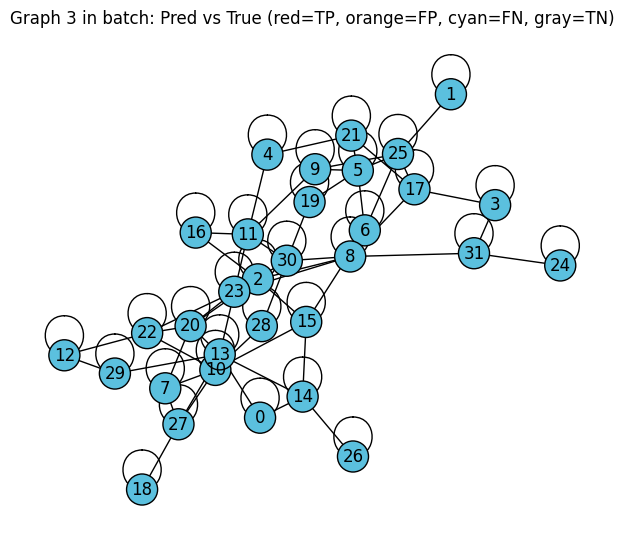

In [16]:
# 可视化：取 test_loader_32 的第一个 batch，但仅绘制其中一个子图以避免混乱
# 颜色：源点=蓝，TP=红，FP=橙，FN=青，TN=灰
import torch
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

nar.eval()
b = next(iter(test_loader_32))  # 取一个批次（这是一个 PyG Batch 对象）
b = b.to('cpu')  # 转到 cpu 以便可视化

# 选择 batch 中的某一个子图索引（可修改为随机或其他索引）
graph_idx_in_batch = 3
# 获取属于该子图的节点索引（在整个 batch 的节点编号空间中）
node_mask = (b.batch == graph_idx_in_batch)
node_indices = node_mask.nonzero(as_tuple=False).view(-1).tolist()
if len(node_indices) == 0:
    raise ValueError(f'No nodes found for graph index {graph_idx_in_batch} in this batch')

# 计算整个 batch 的预测（在 GPU/CPU 上均可），然后再取子集
with torch.no_grad():
    num_nodes = b.pos.size(0)
    x = torch.ones(num_nodes, 1)
    pred_all, _ = nar(x.to(DEVICE), b.edge_index.to(DEVICE), b.batch.to(DEVICE))
    pred_all = pred_all.squeeze(-1).cpu()

# 从完整预测中提取子图节点的预测与真实值
pred = pred_all[node_indices]
reach_true = b.reach_h[:, -1].cpu()[node_indices]

# 将整个 batch 转为 NetworkX，再取对应子图并重标号，便于绘图
G = to_networkx(b, to_undirected=True)
G_sub = G.subgraph(node_indices).copy()
# 重标号为 0..n-1，使索引与 pred/reach_true 一致
mapping = {old: i for i, old in enumerate(node_indices)}
G_sub = nx.relabel_nodes(G_sub, mapping)

# 计算源点在子图中的新索引（若原源点在该子图内）
s = b.s
if s.ndim > 1:
    s = s[:, 0]
old_src = int(torch.argmax(s).item())
src = mapping[old_src] if old_src in mapping else None

pos = nx.spring_layout(G_sub, seed=42)

node_colors = []
for n in range(G_sub.number_of_nodes()):
    p = float(pred[n].item())
    t = float(reach_true[n].item())
    if src is not None and n == src:
        node_colors.append('#2b6cb0')
    elif p > 0.5 and t > 0.5:
        node_colors.append('#d9534f')  # TP
    elif p > 0.5 and t <= 0.5:
        node_colors.append('#f0ad4e')  # FP
    elif p <= 0.5 and t > 0.5:
        node_colors.append('#5bc0de')  # FN
    else:
        node_colors.append('lightgray')  # TN

plt.figure(figsize=(6,5))
nx.draw(G_sub, pos, with_labels=True, node_color=node_colors, node_size=500, edgecolors='black')
plt.title(f'Graph {graph_idx_in_batch} in batch: Pred vs True (red=TP, orange=FP, cyan=FN, gray=TN)')
plt.axis('off')
plt.show()

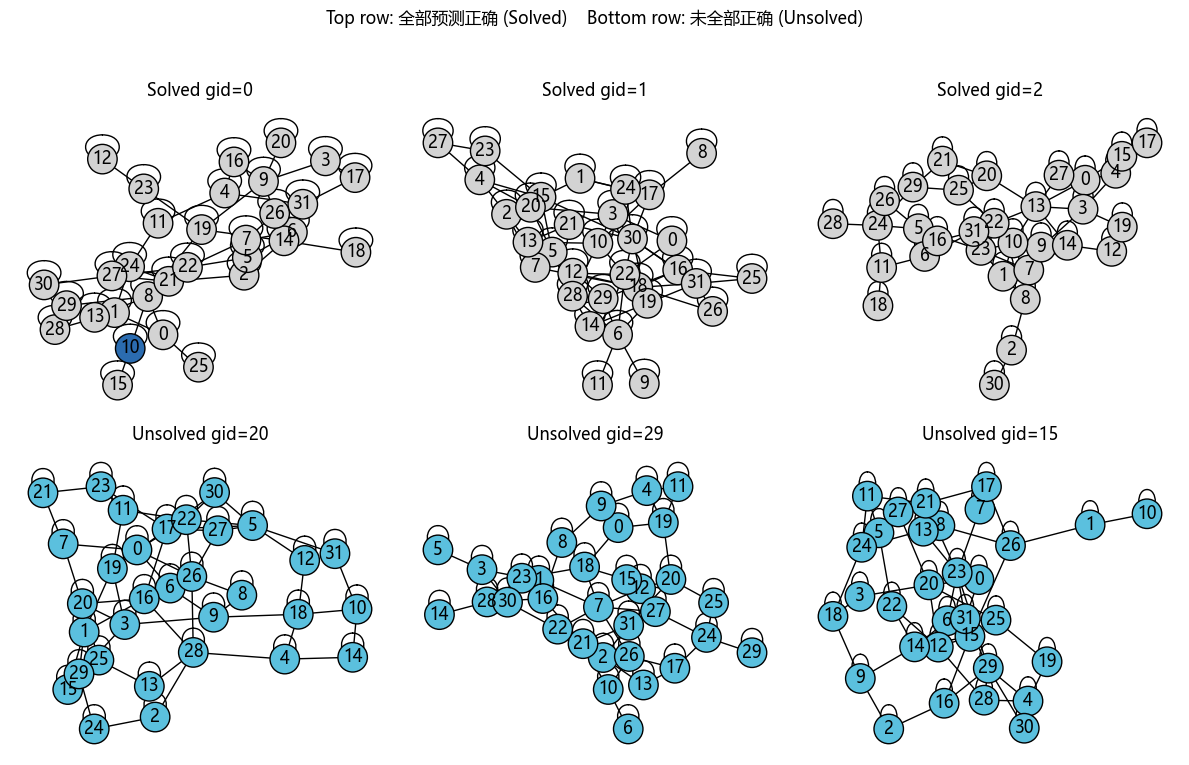

In [20]:
# 颜色说明 + 绘制若干 全解(out_all=True) 与 未全解(out_all=False) 的示例
# 说明：
# - 蓝 (`#2b6cb0`) : 源点 (source)
# - 红 (`#d9534f`) : TP (模型预测为可达，真实也可达)
# - 橙 (`#f0ad4e`) : FP (模型预测为可达，但真实不可达)
# - 青 (`#5bc0de`) : FN (模型预测为不可达，但真实可达)
# - 灰 (`lightgray`) : TN (模型预测不可达，真实也不可达)

import torch
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
import math

# 收集示例：在 test_loader_32 上遍历若干 batch，找到若干完全预测正确和未完全预测正确的子图
max_per_type = 3  # 每类最多展示多少个图（可改）
solved = []
unsolved = []

with torch.no_grad():
    for batch in test_loader_32:
        # 保留 cpu 版本用于构造 networkx 子图和索引映射
        batch_cpu = batch.to('cpu')
        b_dev = batch.to(DEVICE)

        num_nodes = batch_cpu.pos.size(0)
        x = torch.ones(num_nodes, 1, device=DEVICE)
        pred_all, _ = nar(x, b_dev.edge_index, b_dev.batch)
        pred_all = pred_all.squeeze(-1).cpu()
        tgt_all = batch_cpu.reach_h[:, -1].cpu()

        # 对 batch 中每个子图 (graph index) 检查是否所有节点都预测正确
        graph_ids = torch.unique(batch_cpu.batch).tolist()
        for gid in graph_ids:
            mask = (batch_cpu.batch == gid)
            node_indices = mask.nonzero(as_tuple=False).view(-1).tolist()
            if len(node_indices) == 0:
                continue

            pred_bin = (pred_all[node_indices] > 0.5).long()
            tgt_bin = (tgt_all[node_indices] > 0.5).long()
            all_correct = bool((pred_bin == tgt_bin).all())

            example = {
                'node_indices': node_indices,
                'edge_index': batch_cpu.edge_index,
                'pos': batch_cpu.pos,
                's': batch_cpu.s,
                'pred_vals': pred_all[node_indices].tolist(),
                'tgt_vals': tgt_all[node_indices].tolist(),
                'gid': int(gid),
            }

            if all_correct and len(solved) < max_per_type:
                solved.append(example)
            if (not all_correct) and len(unsolved) < max_per_type:
                unsolved.append(example)

            if len(solved) >= max_per_type and len(unsolved) >= max_per_type:
                break
        if len(solved) >= max_per_type and len(unsolved) >= max_per_type:
            break

# 绘制收集到的示例，先绘制全部正确的，再绘制未全部正确的
examples = [('Solved', solved), ('Unsolved', unsolved)]
num_show = sum(min(len(lst), max_per_type) for _, lst in examples)
if num_show == 0:
    print('未找到满足条件的示例。尝试增加扫描的 batch 数或设置更小的阈值。')
else:
    cols = max_per_type
    rows = 2  # solved + unsolved 行
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    if rows == 1:
        axes = [axes]

    for r, (label, lst) in enumerate(examples):
        for c in range(cols):
            ax = axes[r][c] if rows > 1 else axes[c]
            ax.axis('off')
            if c >= len(lst):
                continue
            ex = lst[c]
            node_indices = ex['node_indices']
            edge_index = ex['edge_index']
            pos = ex['pos']
            s = ex['s']
            pred_vals = ex['pred_vals']
            tgt_vals = ex['tgt_vals']
            gid = ex['gid']

            # 将整个 batch 转为 networkx，再取子图并重标号
            G = to_networkx(batch_cpu, to_undirected=True)
            G_sub = G.subgraph(node_indices).copy()
            mapping = {old: i for i, old in enumerate(node_indices)}
            G_sub = nx.relabel_nodes(G_sub, mapping)

            # 源点映射
            s_tmp = s
            if s_tmp.ndim > 1:
                s_tmp = s_tmp[:, 0]
            old_src = int(torch.argmax(s_tmp).item())
            src = mapping[old_src] if old_src in mapping else None

            # 尝试从原始 pos 张量获取坐标（若为 Nx2），否则使用 spring_layout 回退
            try:
                if hasattr(pos, 'ndim') and getattr(pos, 'ndim') >= 2:
                    pos_sub = {mapping[old]: tuple(pos[old].tolist()) for old in node_indices}
                else:
                    raise ValueError('pos not 2D')
            except Exception:
                pos_sub = nx.spring_layout(G_sub, seed=42)

            # 颜色映射（与上面的规则一致）
            node_colors = []
            for n in range(G_sub.number_of_nodes()):
                p = float(pred_vals[n])
                t = float(tgt_vals[n])
                if src is not None and n == src:
                    node_colors.append('#2b6cb0')
                elif p > 0.5 and t > 0.5:
                    node_colors.append('#d9534f')
                elif p > 0.5 and t <= 0.5:
                    node_colors.append('#f0ad4e')
                elif p <= 0.5 and t > 0.5:
                    node_colors.append('#5bc0de')
                else:
                    node_colors.append('lightgray')

            nx.draw(G_sub, pos_sub, ax=ax, with_labels=True, node_color=node_colors, node_size=450, edgecolors='black')
            ax.set_title(f'{label} gid={gid}')

    plt.suptitle('Top row: 全部预测正确 (Solved)    Bottom row: 未全部正确 (Unsolved)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# step7：开始逐步拆解TransNAR

In [2]:
import os, torch

# 切到项目目录
os.chdir("D:\\Desktop\\Neural Symbolic\\Code\\GITCode\\TransNAR")
print("cwd:", os.getcwd())

# 修掉 torch 2.6 的 weights_only=True 默认行为
_orig_load = torch.load
def load_no_weights_only(*args, **kwargs):
    kwargs["weights_only"] = False
    return _orig_load(*args, **kwargs)
torch.load = load_no_weights_only

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

cwd: D:\Desktop\Neural Symbolic\Code\GITCode\TransNAR


'cuda'

In [3]:
import json
from utils.tokenizer import SimpleTokenizer
from torch.utils.data import Dataset, DataLoader

text_path = "data/text/bfs_text_train.jsonl"

# 1) 构建 tokenizer（用整个文本构建词表）
texts = []
with open(text_path, "r", encoding="utf-8") as f:
    for line in f:
        obj = json.loads(line)
        texts.append(obj["text_in"])
        texts.append(obj["text_out"])

tok = SimpleTokenizer(min_freq=1)
tok.build_vocab(texts)
pad_id = tok.token2id[tok.pad_token]
print("vocab_size:", tok.vocab_size, "pad_id:", pad_id)

# 2) 定义一个最小版文本 Dataset（如果你已有 BFSTextSeqDataset 可以直接用）
class BFSTextSeqDataset(Dataset):
    def __init__(self, path, tokenizer, max_len=512):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.data = []
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                self.data.append(json.loads(line))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        obj = self.data[idx]
        in_ids  = self.tokenizer.encode(obj["text_in"],  add_special_tokens=True, max_len=self.max_len)
        out_ids = self.tokenizer.encode(obj["text_out"], add_special_tokens=True, max_len=self.max_len)
        return {
            "input_ids": in_ids,
            "target_ids": out_ids,
            "graph_idx": obj["graph_idx"],
        }

# 3) collate：pad 对齐 batch
def collate_seq_batch(batch, pad_id):
    import torch
    B = len(batch)
    max_len = max(len(x["input_ids"]) for x in batch)

    input_ids  = []
    target_ids = []
    graph_idx  = []

    for item in batch:
        ids_in  = item["input_ids"]
        ids_out = item["target_ids"]
        pad_len_in  = max_len - len(ids_in)
        pad_len_out = max_len - len(ids_out)
        input_ids.append(ids_in + [pad_id] * pad_len_in)
        target_ids.append(ids_out + [pad_id] * pad_len_out)
        graph_idx.append(item["graph_idx"])

    input_ids  = torch.tensor(input_ids, dtype=torch.long)
    target_ids = torch.tensor(target_ids, dtype=torch.long)
    graph_idx  = torch.tensor(graph_idx, dtype=torch.long)

    attention_mask = (input_ids != pad_id)

    return {
        "input_ids": input_ids,
        "target_ids": target_ids,
        "attention_mask": attention_mask,
        "graph_idx": graph_idx,
    }

# 4) 构建 DataLoader 并取一个 batch
text_ds = BFSTextSeqDataset(text_path, tok, max_len=512)
print("文本样本数量:", len(text_ds))

loader = DataLoader(
    text_ds,
    batch_size=2,  # 先用2方便我们看和手算
    shuffle=True,
    collate_fn=lambda b: collate_seq_batch(b, pad_id),
)

text_batch = next(iter(loader))
for k, v in text_batch.items():
    print(k, v.shape, v.dtype)

print("\n第一条 decode:")
print(tok.decode(text_batch["input_ids"][0].tolist()))
print("graph_idx batch:", text_batch["graph_idx"])


vocab_size: 33 pad_id: 0
文本样本数量: 5000
input_ids torch.Size([2, 351]) torch.int64
target_ids torch.Size([2, 351]) torch.int64
attention_mask torch.Size([2, 351]) torch.bool
graph_idx torch.Size([2]) torch.int64

第一条 decode:
bfs : n = 16 , edges = [ ( 0 , 0 ) , ( 0 , 3 ) , ( 0 , 6 ) , ( 0 , 11 ) , ( 0 , 14 ) , ( 1 , 1 ) , ( 1 , 3 ) , ( 1 , 9 ) , ( 1 , 13 ) , ( 2 , 2 ) , ( 2 , 11 ) , ( 3 , 0 ) , ( 3 , 1 ) , ( 3 , 3 ) , ( 3 , 13 ) , ( 4 , 4 ) , ( 4 , 6 ) , ( 5 , 5 ) , ( 5 , 11 ) , ( 6 , 0 ) , ( 6 , 4 ) , ( 6 , 6 ) , ( 7 , 7 ) , ( 7 , 9 ) , ( 7 , 12 ) , ( 7 , 15 ) , ( 8 , 8 ) , ( 8 , 9 ) , ( 8 , 10 ) , ( 8 , 13 ) , ( 9 , 1 ) , ( 9 , 7 ) , ( 9 , 8 ) , ( 9 , 9 ) , ( 10 , 8 ) , ( 10 , 10 ) , ( 10 , 11 ) , ( 11 , 0 ) , ( 11 , 2 ) , ( 11 , 5 ) , ( 11 , 10 ) , ( 11 , 11 ) , ( 11 , 14 ) , ( 12 , 7 ) , ( 12 , 12 ) , ( 12 , 13 ) , ( 13 , 1 ) , ( 13 , 3 ) , ( 13 , 8 ) , ( 13 , 12 ) , ( 13 , 13 ) , ( 14 , 0 ) , ( 14 , 11 ) , ( 14 , 14 ) , ( 15 , 7 ) , ( 15 , 15 ) ] , start = 14
graph_idx batch: tensor

In [4]:
from salsaclrs import SALSACLRSDataset, SALSACLRSDataLoader

# 创建图数据集实例
graph_ds = SALSACLRSDataset(
    root="data/raw",
    split="train", # 训练集
    algorithm="bfs", # BFS 广度优先搜索
    num_samples=10000, # 样本数量
    graph_generator="er", # ER 随机图
    graph_generator_kwargs={"n": 16, "p": 0.1}, # 图生成器参数 n 节点数, p 边概率
    hints=True, # 是否包含提示信息
)

# 输出图数据集的信息
print("num graphs:", len(graph_ds)) # should be 10000 图的数量
g0 = graph_ds[0] # 获取第一个图
print("g0:", g0) # 查看第一个图的详细信息
print("  edge_index shape:", g0.edge_index.shape) # 图结构 BFS输入
print("  pos shape:", g0.pos.shape) # 节点ID
print("  s shape:", g0.s.shape)     # BFS源点
print("  reach_h shape:", g0.reach_h.shape) # 可达高度形状

num graphs: 10000
g0: CLRSData(edge_index=[2, 48], pos=[16], length=8, s=[16], pi=[48], reach_h=[16, 8], pi_h=[48, 8], hints=[2], inputs=[2], outputs=[1])
  edge_index shape: torch.Size([2, 48])
  pos shape: torch.Size([16])
  s shape: torch.Size([16])
  reach_h shape: torch.Size([16, 8])


In [5]:
from torch.utils.data import Dataset
from salsaclrs import SALSACLRSDataLoader

class GraphIndexDataset(Dataset):
    """根据给定的 graph_idx 列表，从原始 SALSACLRSDataSet 里取对应图。"""
    def __init__(self, base_ds, indices):
        self.base_ds = base_ds
        self.indices = list(int(i) for i in indices)
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        return self.base_ds[self.indices[idx]]

# 用 text_batch 里的 graph_idx 构造一个小图数据集
g_indices = text_batch["graph_idx"].tolist()
print("当前 text batch 的 graph_idx:", g_indices)

sub_graph_ds = GraphIndexDataset(graph_ds, g_indices)

graph_loader = SALSACLRSDataLoader(
    sub_graph_ds,
    batch_size=len(sub_graph_ds),  # 一次全取，得到一个合并后的 CLRSDataBatch
    shuffle=False,
)

graph_batch = next(iter(graph_loader))
print("graph_batch:")
print("  edge_index:", graph_batch.edge_index.shape)
print("  pos      :", graph_batch.pos.shape)
print("  reach_h  :", graph_batch.reach_h.shape)
print("  batch vec:", graph_batch.batch.shape, "（每个节点属于第几个图）")


当前 text batch 的 graph_idx: [1646, 1477]
graph_batch:
  edge_index: torch.Size([2, 110])
  pos      : torch.Size([32])
  reach_h  : torch.Size([32, 7])
  batch vec: torch.Size([32]) （每个节点属于第几个图）


In [6]:
from models.nar import NARGNN
import torch.nn as nn

# 和你训练 NAR 时保持一致的参数
nar = NARGNN(
    in_dim=1,
    hidden_dim=128,
    out_dim=1,
    num_layers=4,
).to(DEVICE)

# 加载你之前训练好的权重（路径按你的为准）
state = torch.load("checkpoints/nar_bfs.pt", map_location=DEVICE)
nar.load_state_dict(state)
nar.eval()

graph_batch = graph_batch.to(DEVICE)

# 节点特征 x（这里我们仍然用全 1）
num_nodes = graph_batch.pos.size(0)
x = torch.ones(num_nodes, 1, device=DEVICE)

with torch.no_grad():
    node_logits, node_emb = nar(x, graph_batch.edge_index, graph_batch.batch)

print("node_logits.shape:", node_logits.shape)  # [N_total, 1]
print("node_emb.shape   :", node_emb.shape)     # [N_total, 128]
print("batch vec shape  :", graph_batch.batch.shape)


node_logits.shape: torch.Size([32, 1])
node_emb.shape   : torch.Size([32, 128])
batch vec shape  : torch.Size([32])


In [7]:
import torch

B = text_batch["input_ids"].size(0)
print("batch_size B =", B)

node_emb_packs = []   # 每个元素是 [N_i, d_nar]，第 i 个文本对应的图的节点 embedding
node_batch_packs = [] # 每个元素是 [N_i]，对应节点的 batch 索引（其实全是 i）

for g_idx_in_batch in range(B):
    mask = (graph_batch.batch == g_idx_in_batch)  # [N_total]，属于该图的节点为 True
    emb_i = node_emb[mask]                        # [N_i, d_nar]
    node_emb_packs.append(emb_i)
    node_batch_packs.append(mask.nonzero(as_tuple=False).squeeze(-1))

    print(f"样本 {g_idx_in_batch}: 节点数 = {emb_i.size(0)}")

# 看一下第 0 个样本对应的节点 embedding 形状
node_emb_packs[0].shape


batch_size B = 2
样本 0: 节点数 = 16
样本 1: 节点数 = 16


torch.Size([16, 128])

In [8]:
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer("pe", pe)

    def forward(self, x):
        # x: [B, L, D]
        L = x.size(1)
        return x + self.pe[:, :L, :]

class TextEncoder(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=4, num_layers=2, max_len=512, pad_id=0):
        super().__init__()
        self.pad_id = pad_id
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos = PositionalEncoding(d_model, max_len=max_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, input_ids, attention_mask=None):
        """
        input_ids: [B, L]
        attention_mask: [B, L], True=valid, False=pad
        返回: text_h [B, L, D]
        """
        x = self.embed(input_ids)      # [B,L,D]
        x = self.pos(x)
        src_key_padding_mask = None
        if attention_mask is not None:
            src_key_padding_mask = ~attention_mask.bool()  # True=要mask掉
        h = self.encoder(x, src_key_padding_mask=src_key_padding_mask)
        return h

# 实例化一个文本编码器
vocab_size = tok.vocab_size
text_encoder = TextEncoder(vocab_size=vocab_size, d_model=256, nhead=4, num_layers=2,
                           max_len=512, pad_id=pad_id).to(DEVICE)

text_encoder


TextEncoder(
  (embed): Embedding(33, 256)
  (pos): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
)

In [9]:
input_ids = text_batch["input_ids"].to(DEVICE)          # [B,L]
attention_mask = text_batch["attention_mask"].to(DEVICE)  # [B,L]

with torch.no_grad():
    text_h = text_encoder(input_ids, attention_mask)    # [B,L,256]

print("text_h.shape:", text_h.shape)


text_h.shape: torch.Size([2, 351, 256])


In [10]:
class TextToGraphCrossAttention(nn.Module):
    """
    Text token 作为 Query，图节点 embedding 作为 Key/Value。
    """
    def __init__(self, d_model=256, d_nar=128, nhead=4):
        super().__init__()
        self.nar_proj = nn.Linear(d_nar, d_model)  # 把 NAR embedding 映射到和 text 一样的维度
        self.cross_attn = nn.MultiheadAttention(d_model, nhead, batch_first=True)

    def forward(self, text_h, node_emb_list):
        """
        text_h: [B, L, D]
        node_emb_list: 长度为 B 的 list，其中第 i 个元素形状为 [N_i, d_nar]
        返回:
          cross_out: [B, L, D] （每个 token attend 到图节点后的结果）
        """
        B, L, D = text_h.size()
        outputs = []
        for i in range(B):
            h_i = text_h[i:i+1]              # [1,L,D]，当前样本的 text
            nodes_i = node_emb_list[i]       # [N_i, d_nar]
            nodes_i = nodes_i.to(h_i.device)

            # 投影到 D 维
            kv_i = self.nar_proj(nodes_i)    # [N_i, D]

            # MultiheadAttention 要求 (batch_first=True) 时:
            # Q: [1, L, D], K/V: [1, N_i, D]
            kv_i = kv_i.unsqueeze(0)         # [1, N_i, D]

            # Q=text, K/V=graph nodes
            out_i, attn_weights = self.cross_attn(
                query=h_i,   # [1,L,D]
                key=kv_i,    # [1,N,D]
                value=kv_i,  # [1,N,D]
                need_weights=False
            )               # out_i: [1,L,D]

            outputs.append(out_i)

        return torch.cat(outputs, dim=0)     # [B,L,D]


cross_attn_module = TextToGraphCrossAttention(d_model=256, d_nar=128, nhead=4).to(DEVICE)
cross_attn_module


TextToGraphCrossAttention(
  (nar_proj): Linear(in_features=128, out_features=256, bias=True)
  (cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
)

In [11]:
with torch.no_grad():
    cross_out = cross_attn_module(text_h, node_emb_packs)   # [B,L,D]

print("cross_out.shape:", cross_out.shape)


cross_out.shape: torch.Size([2, 351, 256])


In [12]:
class MiniTransNARHead(nn.Module):
    def __init__(self, d_model, vocab_size):
        super().__init__()
        self.ln = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size)

    def forward(self, text_h, cross_out):
        # 简单做个残差 + LayerNorm
        fused = text_h + cross_out
        fused = self.ln(fused)
        logits = self.lm_head(fused)  # [B,L,V]
        return logits

head = MiniTransNARHead(d_model=256, vocab_size=vocab_size).to(DEVICE)

with torch.no_grad():
    logits = head(text_h, cross_out)

print("logits.shape:", logits.shape)  # 期待 [B, L, vocab_size]


logits.shape: torch.Size([2, 351, 33])


In [1]:
import os
import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# =======================
# 0. 基本设置
# =======================
# 改成你的 TransNAR 项目根目录
os.chdir("D:\\Desktop\\Neural Symbolic\\Code\\GITCode\\TransNAR")
print("cwd:", os.getcwd())

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

# 解决 torch.load(weights_only=True) 的问题（和你 train_nar / train_transnar 里一样）
_orig_torch_load = torch.load
def torch_load_no_weights_only(*args, **kwargs):
    kwargs["weights_only"] = False
    return _orig_torch_load(*args, **kwargs)
torch.load = torch_load_no_weights_only

# =======================
# 1. 导入你已经写好的类 / 函数
# =======================
from train_transnar_1 import (
    BFSTextSeqDataset, collate_seq_batch,
    make_graph_batch,
    TextEncoder, TextToGraphCrossAttention,
    MiniTransNARHead,
    NARGNN,
)
from utils.tokenizer import SimpleTokenizer
from salsaclrs import SALSACLRSDataset, SALSACLRSDataLoader

# =======================
# 2. 手工设置一些路径和超参数（照你之前训练时的设置）
# =======================
TEXT_TRAIN_PATH = "data/text/bfs_text_train.jsonl"   # 训练时用来建 vocab 的 jsonl
TEXT_TEST_PATH  = "data/text/bfs_text_test_32.jsonl"    # ⭐ 你的“新数据集”的文本文件
RAW_GRAPH_ROOT  = "data/raw"                         # SALSA-CLRS 图数据根目录
GRAPH_SPLIT     = "train"                            # ⭐ 如果你新图是用 split='test' 生成，就改成 "test"

NAR_CKPT_PATH      = "checkpoints/nar_bfs.pt"         # 你之前训练好的 NAR
TRANSNAR_CKPT_PATH = "checkpoints/transnar_bfs.pt"    # 你训练好的 TransNAR（或某个 epoch 文件）

# 这些超参数要和你训练时一致（就是 train_transnar.py 里那几个）
GRAPH_N   = 32
GRAPH_P   = 0.1
NUM_SAMPLES = 10000
MAX_LEN   = 512
D_MODEL   = 256
NHEAD     = 4
NUM_LAYERS_TEXT = 2
NAR_IN_DIM     = 1
NAR_HIDDEN_DIM = 128
NAR_OUT_DIM    = 1
NAR_NUM_LAYERS = 4


# =======================
# 3. 构建 tokenizer（用训练数据的 text 建 vocab）
# =======================
train_texts = []
with open(TEXT_TRAIN_PATH, "r", encoding="utf-8") as f:
    for line in f:
        obj = json.loads(line)
        train_texts.append(obj["text_in"])
        train_texts.append(obj["text_out"])

tokenizer = SimpleTokenizer(min_freq=1)
tokenizer.build_vocab(train_texts)
pad_id = tokenizer.token2id[tokenizer.pad_token]
vocab_size = tokenizer.vocab_size
print("vocab_size:", vocab_size, "pad_id:", pad_id)

# =======================
# 4. 构建【测试文本】数据集和 DataLoader
# =======================
test_ds = BFSTextSeqDataset(TEXT_TEST_PATH, tokenizer, max_len=MAX_LEN)
test_loader = DataLoader(
    test_ds,
    batch_size=2,  # 测试用小一点的 batch，方便 debug
    shuffle=False,
    collate_fn=lambda b: collate_seq_batch(b, pad_id),
)
print("Test dataset size:", len(test_ds))

# 看一眼 batch 结构
batch0 = next(iter(test_loader))
for k, v in batch0.items():
    print("batch0", k, v.shape)
del batch0  # 不占显存


# =======================
# 5. 构建【图数据】（SALSACLRSDataSet）
# =======================
graph_ds = SALSACLRSDataset(
    root=RAW_GRAPH_ROOT,
    split=GRAPH_SPLIT,
    algorithm="bfs",
    num_samples=NUM_SAMPLES,
    graph_generator="er",
    graph_generator_kwargs={"n": GRAPH_N, "p": GRAPH_P},
    hints=True,
)
print("Graph dataset size:", len(graph_ds))


# =======================
# 6. 加载 NAR（冻结）
# =======================
nar = NARGNN(
    in_dim=NAR_IN_DIM,
    hidden_dim=NAR_HIDDEN_DIM,
    out_dim=NAR_OUT_DIM,
    num_layers=NAR_NUM_LAYERS,
).to(DEVICE)

nar_state = torch.load(NAR_CKPT_PATH, map_location=DEVICE)
nar.load_state_dict(nar_state)
nar.eval()
for p in nar.parameters():
    p.requires_grad = False

print("Loaded NAR from", NAR_CKPT_PATH)


# =======================
# 7. 加载 TransNAR（三个子模块）
# =======================
ckpt = torch.load(TRANSNAR_CKPT_PATH, map_location=DEVICE)
print("Loaded TransNAR from", TRANSNAR_CKPT_PATH)

# 如果你训练时保存了 config，就从 checkpoint 里读，否则用上面的手工超参
cfg_dict = ckpt.get("config", {})

d_model_eval   = cfg_dict.get("d_model", D_MODEL)
nhead_eval     = cfg_dict.get("nhead", NHEAD)
layers_eval    = cfg_dict.get("num_layers_text", NUM_LAYERS_TEXT)
max_len_eval   = cfg_dict.get("max_len", MAX_LEN)
nar_hidden_eval = cfg_dict.get("nar_hidden_dim", NAR_HIDDEN_DIM)

text_encoder = TextEncoder(
    vocab_size=vocab_size,
    d_model=d_model_eval,
    nhead=nhead_eval,
    num_layers=layers_eval,
    max_len=max_len_eval,
    pad_id=pad_id,
).to(DEVICE)

cross_attn_module = TextToGraphCrossAttention(
    d_model=d_model_eval,
    d_nar=nar_hidden_eval,
    nhead=nhead_eval,
).to(DEVICE)

head = MiniTransNARHead(
    d_model=d_model_eval,
    vocab_size=vocab_size,
).to(DEVICE)

text_encoder.load_state_dict(ckpt["text_encoder"])
cross_attn_module.load_state_dict(ckpt["cross_attn"])
head.load_state_dict(ckpt["head"])

text_encoder.eval()
cross_attn_module.eval()
head.eval()

print("TransNAR modules loaded & set to eval().")


# =======================
# 8. 在新数据集上做【纯测试前向】
# =======================
criterion = nn.CrossEntropyLoss(ignore_index=pad_id, reduction="sum")

total_loss = 0.0
total_tokens = 0
total_correct = 0
first_batch = True

for batch in test_loader:
    input_ids = batch["input_ids"].to(DEVICE)            # [B,L]
    target_ids = batch["target_ids"].to(DEVICE)          # [B,L]
    attention_mask = batch["attention_mask"].to(DEVICE)  # [B,L]
    graph_idx = batch["graph_idx"]                       # [B]

    B, L = input_ids.shape

    # (1) graph_idx -> graph_batch
    graph_batch = make_graph_batch(graph_ds, graph_idx.tolist()).to(DEVICE)

    # (2) NAR 前向：拿到节点 embedding
    num_nodes = graph_batch.pos.size(0)
    x_nodes = torch.ones(num_nodes, 1, device=DEVICE)
    with torch.no_grad():
        _, node_emb = nar(x_nodes, graph_batch.edge_index, graph_batch.batch)  # [N_total, d_nar]

    # (3) 按样本拆 node_emb
    node_emb_list = []
    for i in range(B):
        mask = (graph_batch.batch == i)
        node_emb_list.append(node_emb[mask])

    # (4) TextEncoder + CrossAttention + Head
    with torch.no_grad():
        text_h = text_encoder(input_ids, attention_mask=attention_mask)   # [B,L,D]
        cross_out = cross_attn_module(text_h, node_emb_list)              # [B,L,D]
        logits = head(text_h, cross_out)                                  # [B,L,V]

    # (5) 计算 loss 和 token-level accuracy
    loss = criterion(
        logits.view(-1, vocab_size),
        target_ids.view(-1),
    )
    total_loss += loss.item()

    mask = (target_ids != pad_id)
    pred_ids = logits.argmax(dim=-1)
    total_correct += ((pred_ids == target_ids) & mask).sum().item()
    total_tokens += mask.sum().item()

    # 打印第一个 batch 的预测，方便你肉眼看看
    if first_batch:
        first_batch = False
        print("\n=== Example on NEW test set ===")
        print("graph_idx batch:", graph_idx.tolist())
        print("input text_in:")
        print(tokenizer.decode(batch["input_ids"][0].tolist()))
        print("true text_out:")
        print(tokenizer.decode(batch["target_ids"][0].tolist()))
        print("pred text_out:")
        print(tokenizer.decode(pred_ids[0].tolist()))

avg_loss = total_loss / max(1, total_tokens)
acc = total_correct / max(1, total_tokens)

print("\n====== Eval Result on NEW DATA ======")
print("Avg loss per token:", avg_loss)
print("Token accuracy    :", acc)


cwd: D:\Desktop\Neural Symbolic\Code\GITCode\TransNAR
DEVICE: cuda
vocab_size: 33 pad_id: 0
Test dataset size: 5000
batch0 input_ids torch.Size([2, 512])
batch0 target_ids torch.Size([2, 512])
batch0 graph_idx torch.Size([2])
batch0 attention_mask torch.Size([2, 512])
Graph dataset size: 10000
Loaded NAR from checkpoints/nar_bfs.pt
Loaded TransNAR from checkpoints/transnar_bfs.pt
TransNAR modules loaded & set to eval().


c:\Users\admin\.conda\envs\torch128\Lib\site-packages\torch\nn\modules\transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(



=== Example on NEW test set ===
graph_idx batch: [0, 1]
input text_in:
bfs : n = <unk> , edges = [ ( 0 , 0 ) , ( 0 , 13 ) , ( 1 , 1 ) , ( 1 , <unk> ) , ( 1 , <unk> ) , ( 2 , 2 ) , ( 2 , 8 ) , ( 2 , 9 ) , ( 3 , 3 ) , ( 3 , 15 ) , ( 3 , <unk> ) , ( 4 , 4 ) , ( 4 , 7 ) , ( 4 , 11 ) , ( 4 , 13 ) , ( 4 , <unk> ) , ( 4 , <unk> ) , ( 4 , <unk> ) , ( 5 , 5 ) , ( 5 , 10 ) , ( 5 , <unk> ) , ( 5 , <unk> ) , ( 5 , <unk> ) , ( 6 , 6 ) , ( 6 , 8 ) , ( 6 , 11 ) , ( 6 , 13 ) , ( 6 , <unk> ) , ( 7 , 4 ) , ( 7 , 7 ) , ( 7 , 9 ) , ( 7 , <unk> ) , ( 8 , 2 ) , ( 8 , 6 ) , ( 8 , 8 ) , ( 8 , <unk> ) , ( 8 , <unk> ) , ( 8 , <unk> ) , ( 9 , 2 ) , ( 9 , 7 ) , ( 9 , 9 ) , ( 9 , 13 ) , ( 9 , 14 ) , ( 9 , <unk> ) , ( 9 , <unk> ) , ( 9 , <unk> ) , ( 9 , <unk> ) , ( 10 , 5 ) , ( 10 , 10 ) , ( 11 , 4 ) , ( 11 , 6 ) , ( 11 , 11 ) , ( 11 , <unk> ) , ( 11 , <unk> ) , ( 11 , <unk> ) , ( 12 , 12 ) , ( 12 , <unk> ) , ( 12 , <unk> ) , ( 12 , <unk> ) , ( 13 , 0 ) , ( 13 , 4 ) , ( 13 , 6 ) , ( 13 , 9 ) , ( 13 , 13 ) , ( 14 ,